In [1]:
from torch import FloatTensor, LongTensor
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Module(object):
    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

In [3]:
class Linear(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(Linear).__init__()

        self.name = 'Linear'

        self.in_features = in_features
        self.out_features = out_features

        self.weight = FloatTensor(in_features, out_features)
        self.weight_grad = FloatTensor(in_features, out_features)

        if bias:
            self.bias = FloatTensor(out_features)
            self.bias_grad = FloatTensor(out_features)
        else:
            self.bias = None
            self.bias_grad = None

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(0))
        self.weight.uniform_(-stdv, stdv)
        self.weight_grad.fill_(0)
        if self.bias is not None:
            self.bias.uniform_(-stdv, stdv)
            self.bias_grad.fill_(0)

    def forward(self, input):
        # Y = X * W + b
        self.input = input.clone()
        if self.bias is not None:
            return self.input.matmul(self.weight).add(self.bias)
        else:
            return self.input.matmul(self.weight)

    def backward(self, gradwrtoutput):
        # dW = X^T * dL/dY
        self.weight_grad = self.input.t().matmul(gradwrtoutput)
        # db = (dL/dY)^T * 1
        if self.bias is not None:
            self.bias_grad = gradwrtoutput.t().sum(1)
        # dX = dL/dY * W^T
        return gradwrtoutput.matmul(self.weight.t())

    def param(self):
        if self.bias is not None:
            return [(self.weight, self.weight_grad),
                    (self.bias, self.bias_grad)]
        else:
            return [(self.weight, self.weight_grad)]

In [4]:
class ReLU(Module):
    def __init__(self):
        super(ReLU).__init__()

        self.name = 'ReLU'

    def forward(self, input):
        # Y = max(0,X)
        self.input = input.clone()
        return self.input.mul(self.input.gt(0).float())

    def backward(self, gradwrtoutput):
        if self.input is not None:
            return gradwrtoutput.mul(self.input.gt(0).float())
        else:
            print("Forward First")
            return None

    def param(self):
        return []

In [5]:
class Tanh(Module):
    def __init__(self):
        super(Tanh).__init__()
        self.name = 'Tanh'

    def forward(self, input):
        # Y = (exp(X) - exp(-X))/(exp(X) + exp(-X))
        self.input = input.clone()
        return self.input.tanh()
        # self.input.masked_fill_(self.input.gt(50), 50)  # prevent overflow
        # return (self.input.exp() - self.input.mul(-1).exp()) / (self.input.exp() + self.input.mul(-1).exp())

    def backward(self, gradwrtoutput):
        # dY/dX = 4/(exp(x) + exp(-x))^2
        if self.input is not None:
            grad = 4. / (self.input.exp() + self.input.mul(-1).exp()).pow(2)
            return gradwrtoutput.mul(grad)
        else:
            print("Forward First")
            return None

    def param(self):
        return []

In [6]:
class Sequential(Module):
    def __init__(self):
        super(Sequential).__init__()
        self.name = 'Sequential'
        self.module_list = []

    def add(self, *module):
        for m in module:
            self.module_list.append(m)

    def forward(self, input):
        module_input = input.clone()
        for module in self.module_list:
            module_output = module.forward(module_input)
            module_input = module_output
        return module_output

    def backward(self, gradwrtoutput):
        grad = gradwrtoutput
        for module in self.module_list[::-1]:
            grad = module.backward(grad)
        # return grad

    def param(self):
        return [module.param() for module in self.module_list]

In [7]:
class LossMSE():
    def __init__(self):
        super(LossMSE).__init__()
        self.name = 'LossMSE'

    def forward(self, predict_value, true_value):
        self.predict_value = predict_value
        self.true_value = true_value
        self.loss = (self.predict_value - self.true_value).float().pow(2).mean()
        return self.loss

    def backward(self):
        return 2 * (self.predict_value - self.true_value).float()

In [8]:
def reshapeLabel(label):
    '''
    Reshape 1-D [0,1,...] to 2-D [[1,-1],[-1,1],...].
    '''
    n = label.size(0)
    y = FloatTensor(n, 2)
    y[:, 0] = 2 * (0.5 - label)
    y[:, 1] = - y[:, 0]
    return y.long()

In [175]:
X_train = FloatTensor(1000, 2).uniform_(0, 1)
y_label_train = X_train.sub(0.5).pow(2).sum(1).lt(1./2./math.pi).float()
y_train = reshapeLabel(y_label_train)

X_test = FloatTensor(1000, 2).uniform_(0, 1)
y_label_test = X_test.sub(0.5).pow(2).sum(1).lt(1./2./math.pi).float()
y_test = reshapeLabel(y_label_test)

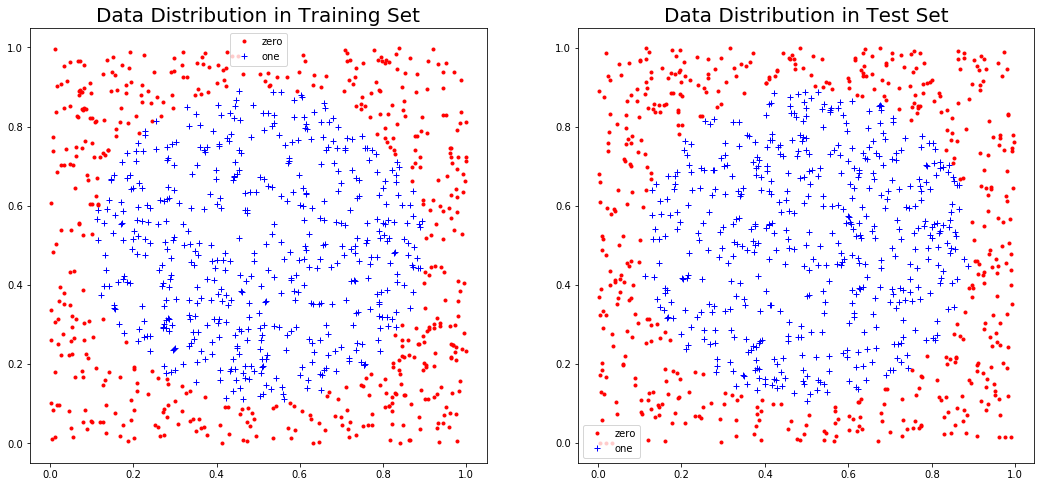

In [176]:
# Plot 
fig, ax = plt.subplots(1, 2, figsize=(18,8))
zero_index = np.where(y_label_train==0)[0]
one_index = np.where(y_label_train==1)[0]
ax[0].plot(np.array(X_train)[zero_index, 0], np.array(X_train)[zero_index, 1], 'r.', label='zero')
ax[0].plot(np.array(X_train)[one_index, 0], np.array(X_train)[one_index, 1], 'b+', label='one')
ax[0].set_title('Data Distribution in Training Set', size=20)
ax[0].legend();

zero_index = np.where(y_label_test==0)[0]
one_index = np.where(y_label_test==1)[0]
ax[1].plot(np.array(X_test)[zero_index, 0], np.array(X_test)[zero_index, 1], 'r.', label='zero')
ax[1].plot(np.array(X_test)[one_index, 0], np.array(X_test)[one_index, 1], 'b+', label='one')
ax[1].set_title('Data Distribution in Test Set', size=20)
ax[1].legend();

In [177]:
# Normalization
mu, std = X_train.mean(), X_train.std()
X_train.sub_(mu).div_(std)
X_test.sub_(mu).div_(std);

In [ ]:
train_output = model.forward(X_train)
print("Before Train Error: {:.2%}".format(train_output.max(1)[1].ne(y_train.max(1)[1]).sum()/train_output.size(0)))

In [229]:
model = Sequential()
#model.add(Linear(2, 25), ReLU(), Linear(25, 2), Tanh())
model.add(Linear(2, 25), ReLU(), 
          Linear(25, 25), ReLU(),
          Linear(25, 25), ReLU(),
          Linear(25, 2), Tanh())

In [230]:
lr = 0.01
mini_batch_size = 50
epoch = 10

criterion = LossMSE()

error_log4 = []

for e in range(epoch):
    print("******** Begin Epoch {} ********\n".format(e))
    for b in range(0, X_train.size(0), mini_batch_size):
        output = model.forward(X_train.narrow(0, b, mini_batch_size))
        loss = criterion.forward(output, y_train.narrow(0, b, mini_batch_size).float())
        error = output.max(1)[1].ne(y_train.narrow(0, b, mini_batch_size).max(1)[1]).sum()/output.size(0)
        print("Epoch {} Batch {:2.0f}: {:4.2f}, {:6.2%}".format(e, b/mini_batch_size, loss, error))
        l_grad = criterion.backward()
        #print(l_grad)
        model.backward(l_grad)
        for layer in model.param():
            for p in layer:
                p[0].sub_(lr*p[1])
    
    print("\n******** After Epoch {} ********\n".format(e))
    output = model.forward(X_train)
    loss = criterion.forward(output, y_train.float())
    error = output.max(1)[1].ne(y_train.max(1)[1]).sum()/output.size(0)
    error_log4.append(error)
    print("Loss: {:4.2f}, Error: {:6.2%}\n".format(loss, error))
    #print(e, criterion.calculate(model.forward(X_train), y_train.float()))

******** Begin Epoch 0 ********

Epoch 0 Batch  0: 0.99, 44.00%
Epoch 0 Batch  1: 0.97, 38.00%
Epoch 0 Batch  2: 0.98, 42.00%
Epoch 0 Batch  3: 1.18, 66.00%
Epoch 0 Batch  4: 1.46, 58.00%
Epoch 0 Batch  5: 1.00, 50.00%
Epoch 0 Batch  6: 0.99, 46.00%
Epoch 0 Batch  7: 1.13, 56.00%
Epoch 0 Batch  8: 0.96, 40.00%
Epoch 0 Batch  9: 1.03, 52.00%
Epoch 0 Batch 10: 0.97, 44.00%
Epoch 0 Batch 11: 0.97, 50.00%
Epoch 0 Batch 12: 0.93, 42.00%
Epoch 0 Batch 13: 1.09, 48.00%
Epoch 0 Batch 14: 0.97, 46.00%
Epoch 0 Batch 15: 0.94, 28.00%
Epoch 0 Batch 16: 1.02, 54.00%
Epoch 0 Batch 17: 0.93, 46.00%
Epoch 0 Batch 18: 0.92, 42.00%
Epoch 0 Batch 19: 1.03, 50.00%

******** After Epoch 0 ********

Loss: 1.11, Error: 49.90%

******** Begin Epoch 1 ********

Epoch 1 Batch  0: 1.05, 46.00%
Epoch 1 Batch  1: 0.99, 54.00%
Epoch 1 Batch  2: 1.12, 54.00%
Epoch 1 Batch  3: 1.07, 66.00%
Epoch 1 Batch  4: 1.27, 58.00%
Epoch 1 Batch  5: 0.98, 48.00%
Epoch 1 Batch  6: 0.97, 52.00%
Epoch 1 Batch  7: 1.28, 56.00%
Epoch

In [231]:
train_output = model.forward(X_train)
print("Train Error: {:.2%}".format(train_output.max(1)[1].ne(y_train.max(1)[1]).sum()/train_output.size(0)))

test_output = model.forward(X_test)
print("Test Error: {:.2%}".format(test_output.max(1)[1].ne(y_test.max(1)[1]).sum()/test_output.size(0)))

Train Error: 8.60%
Test Error: 9.00%


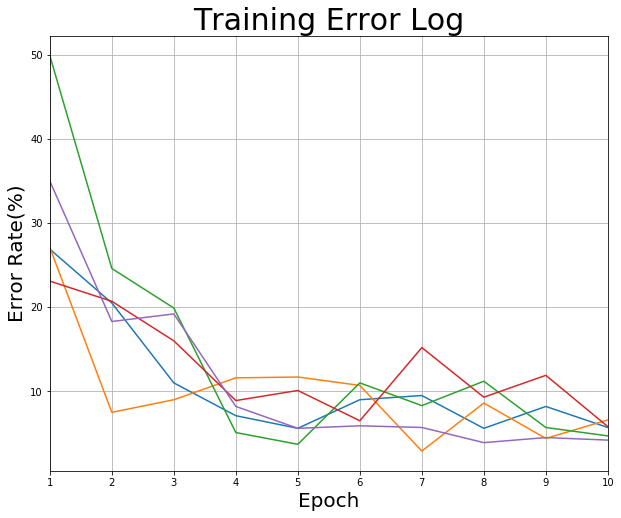

In [228]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11), np.array(error_log)*100)
plt.plot(range(1,11), np.array(error_log1)*100)
plt.plot(range(1,11), np.array(error_log2)*100)
plt.plot(range(1,11), np.array(error_log3)*100)
plt.plot(range(1,11), np.array(error_log4)*100)
plt.xlim(1,10)
plt.grid()
plt.xlabel("Epoch", size=20)
plt.ylabel("Error Rate(%)", size=20)
plt.title("Training Error Log", size=30)
plt.savefig("training.jpg")  ;


---

In [20]:
import torch
from torch import nn, optim 
from torch.nn import functional as F 
from torch.autograd import Variable

In [103]:
X_train = FloatTensor(1000, 2).uniform_(0, 1)
y_label_train = X_train.sub(0.5).pow(2).sum(1).lt(1./2./math.pi).float()
y_train = reshapeLabel(y_label_train)

X_test = FloatTensor(1000, 2).uniform_(0, 1)
y_label_test = X_test.sub(0.5).pow(2).sum(1).lt(1./2./math.pi).float()
y_test = reshapeLabel(y_label_test)

In [104]:
# convert to Variable
X_train, y_train = Variable(X_train), Variable(y_train)
X_test, y_test = Variable(X_test), Variable(y_test)

In [105]:
mu, std = X_train.mean(), X_train.std()
X_train.sub_(mu).div_(std)
X_test.sub_(mu).div_(std);

y_train = y_train.float()
y_test = y_test.float()

In [62]:
train_output = model.forward(X_train)
print("Before Train Error: {:.2%}".format(float(train_output.max(1)[1].ne(y_train.max(1)[1]).sum())/train_output.size(0)))

Before Train Error: 24.80%


In [172]:
model = nn.Sequential(
        nn.Linear(2,25),
        nn.ReLU(),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.Linear(25,2),
        nn.Tanh(),
)

In [173]:
%%time
lr = 0.01
batch_size = 50
nb_epochs = 10

criterion = nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=lr)

for k in range(nb_epochs):
    print("******** Begin Epoch {} ********\n".format(k))
    for b in range(0, X_train.size(0), batch_size):
        output = model.forward(X_train.narrow(0, b, batch_size)) 
        loss = criterion(output , y_train.narrow(0, b, batch_size))
        error = float(output.max(1)[1].ne(y_train.narrow(0, b, batch_size).max(1)[1]).sum())/output.size(0)
        print("Epoch {} Batch {:2.0f}: {:4.2f}, {:6.2%}".format(k, b/batch_size, loss.data[0], error))
        model.zero_grad()
        loss.backward()
        optimizer.step()
    
    print("\n******** After Epoch {} ********\n".format(k))
    output = model.forward(X_train)
    loss = criterion(output, y_train.float())
    error = float(output.max(1)[1].ne(y_train.max(1)[1]).sum())/output.size(0)
    print("Loss: {:4.2f}, Error: {:6.2%}\n".format(loss.data[0], error))

******** Begin Epoch 0 ********

Epoch 0 Batch  0: 1.00, 46.00%
Epoch 0 Batch  1: 1.00, 44.00%
Epoch 0 Batch  2: 1.01, 56.00%
Epoch 0 Batch  3: 1.03, 68.00%
Epoch 0 Batch  4: 1.01, 54.00%
Epoch 0 Batch  5: 1.01, 56.00%
Epoch 0 Batch  6: 1.01, 58.00%
Epoch 0 Batch  7: 1.01, 56.00%
Epoch 0 Batch  8: 1.01, 50.00%
Epoch 0 Batch  9: 1.00, 50.00%
Epoch 0 Batch 10: 1.00, 48.00%
Epoch 0 Batch 11: 1.00, 44.00%
Epoch 0 Batch 12: 1.01, 52.00%
Epoch 0 Batch 13: 1.00, 44.00%
Epoch 0 Batch 14: 1.00, 44.00%
Epoch 0 Batch 15: 1.01, 52.00%
Epoch 0 Batch 16: 1.00, 40.00%
Epoch 0 Batch 17: 1.01, 46.00%
Epoch 0 Batch 18: 1.00, 38.00%
Epoch 0 Batch 19: 1.00, 36.00%

******** After Epoch 0 ********

Loss: 1.00, Error: 16.10%

******** Begin Epoch 1 ********

Epoch 1 Batch  0: 1.00, 40.00%
Epoch 1 Batch  1: 0.99, 36.00%
Epoch 1 Batch  2: 1.00, 50.00%
Epoch 1 Batch  3: 1.00, 50.00%
Epoch 1 Batch  4: 1.00, 48.00%
Epoch 1 Batch  5: 1.01, 44.00%
Epoch 1 Batch  6: 0.99, 38.00%
Epoch 1 Batch  7: 0.99, 36.00%
Epoch

In [174]:
train_output = model.forward(X_train)
print("Train Error: {:.2%}".format(float(train_output.max(1)[1].ne(y_train.max(1)[1]).sum())/train_output.size(0)))

test_output = model.forward(X_test)
print("Test Error: {:.2%}".format(float(test_output.max(1)[1].ne(y_test.max(1)[1]).sum())/test_output.size(0)))

Train Error: 3.60%
Test Error: 8.50%
